# Predicting Scottish A&E Attendances
In this notebook, I will be use machine learning to forecast scottish A&E attendances across different hospitals

In [60]:
import IPython
import IPython.display
import csv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

mpl.rcParams['figure.figsize'] = (10, 10)
mpl.rcParams['axes.grid'] = False

In [3]:
df = pd.read_csv('/Users/nng3/Masters/Semester 3/Project 1/load_data.csv')
df.drop(['Unnamed: 0', 'HBT', 'monthyr', 'dpttype', 'day', 'week', 'hr', 'inout', 'Postcode', 'size'], axis=1, inplace=True)
df.head()

,loc,attendances,hr.num,day.num,year,month,cmonth,chr,covid
0,A111H,20,0,5,2018,1,1,96,0
1,A111H,14,1,5,2018,1,1,97,0
2,A111H,6,2,5,2018,1,1,98,0
3,A111H,5,3,5,2018,1,1,99,0
4,A111H,5,4,5,2018,1,1,100,0


In [4]:
# Generate year numbers
year_num_dict = {2018: 1, 2019: 2, 2020: 3, 2021: 4, 2022:5, 2023:6, 2024:7}
df['year_num'] = df['year'].map(year_num_dict)

# Generate an index for each loc
df.sort_values(by=['loc','cmonth', 'chr']).reset_index(drop=True)
df['row_index'] = df.groupby('loc').cumcount() + 1

# Exploratory Data Analysis

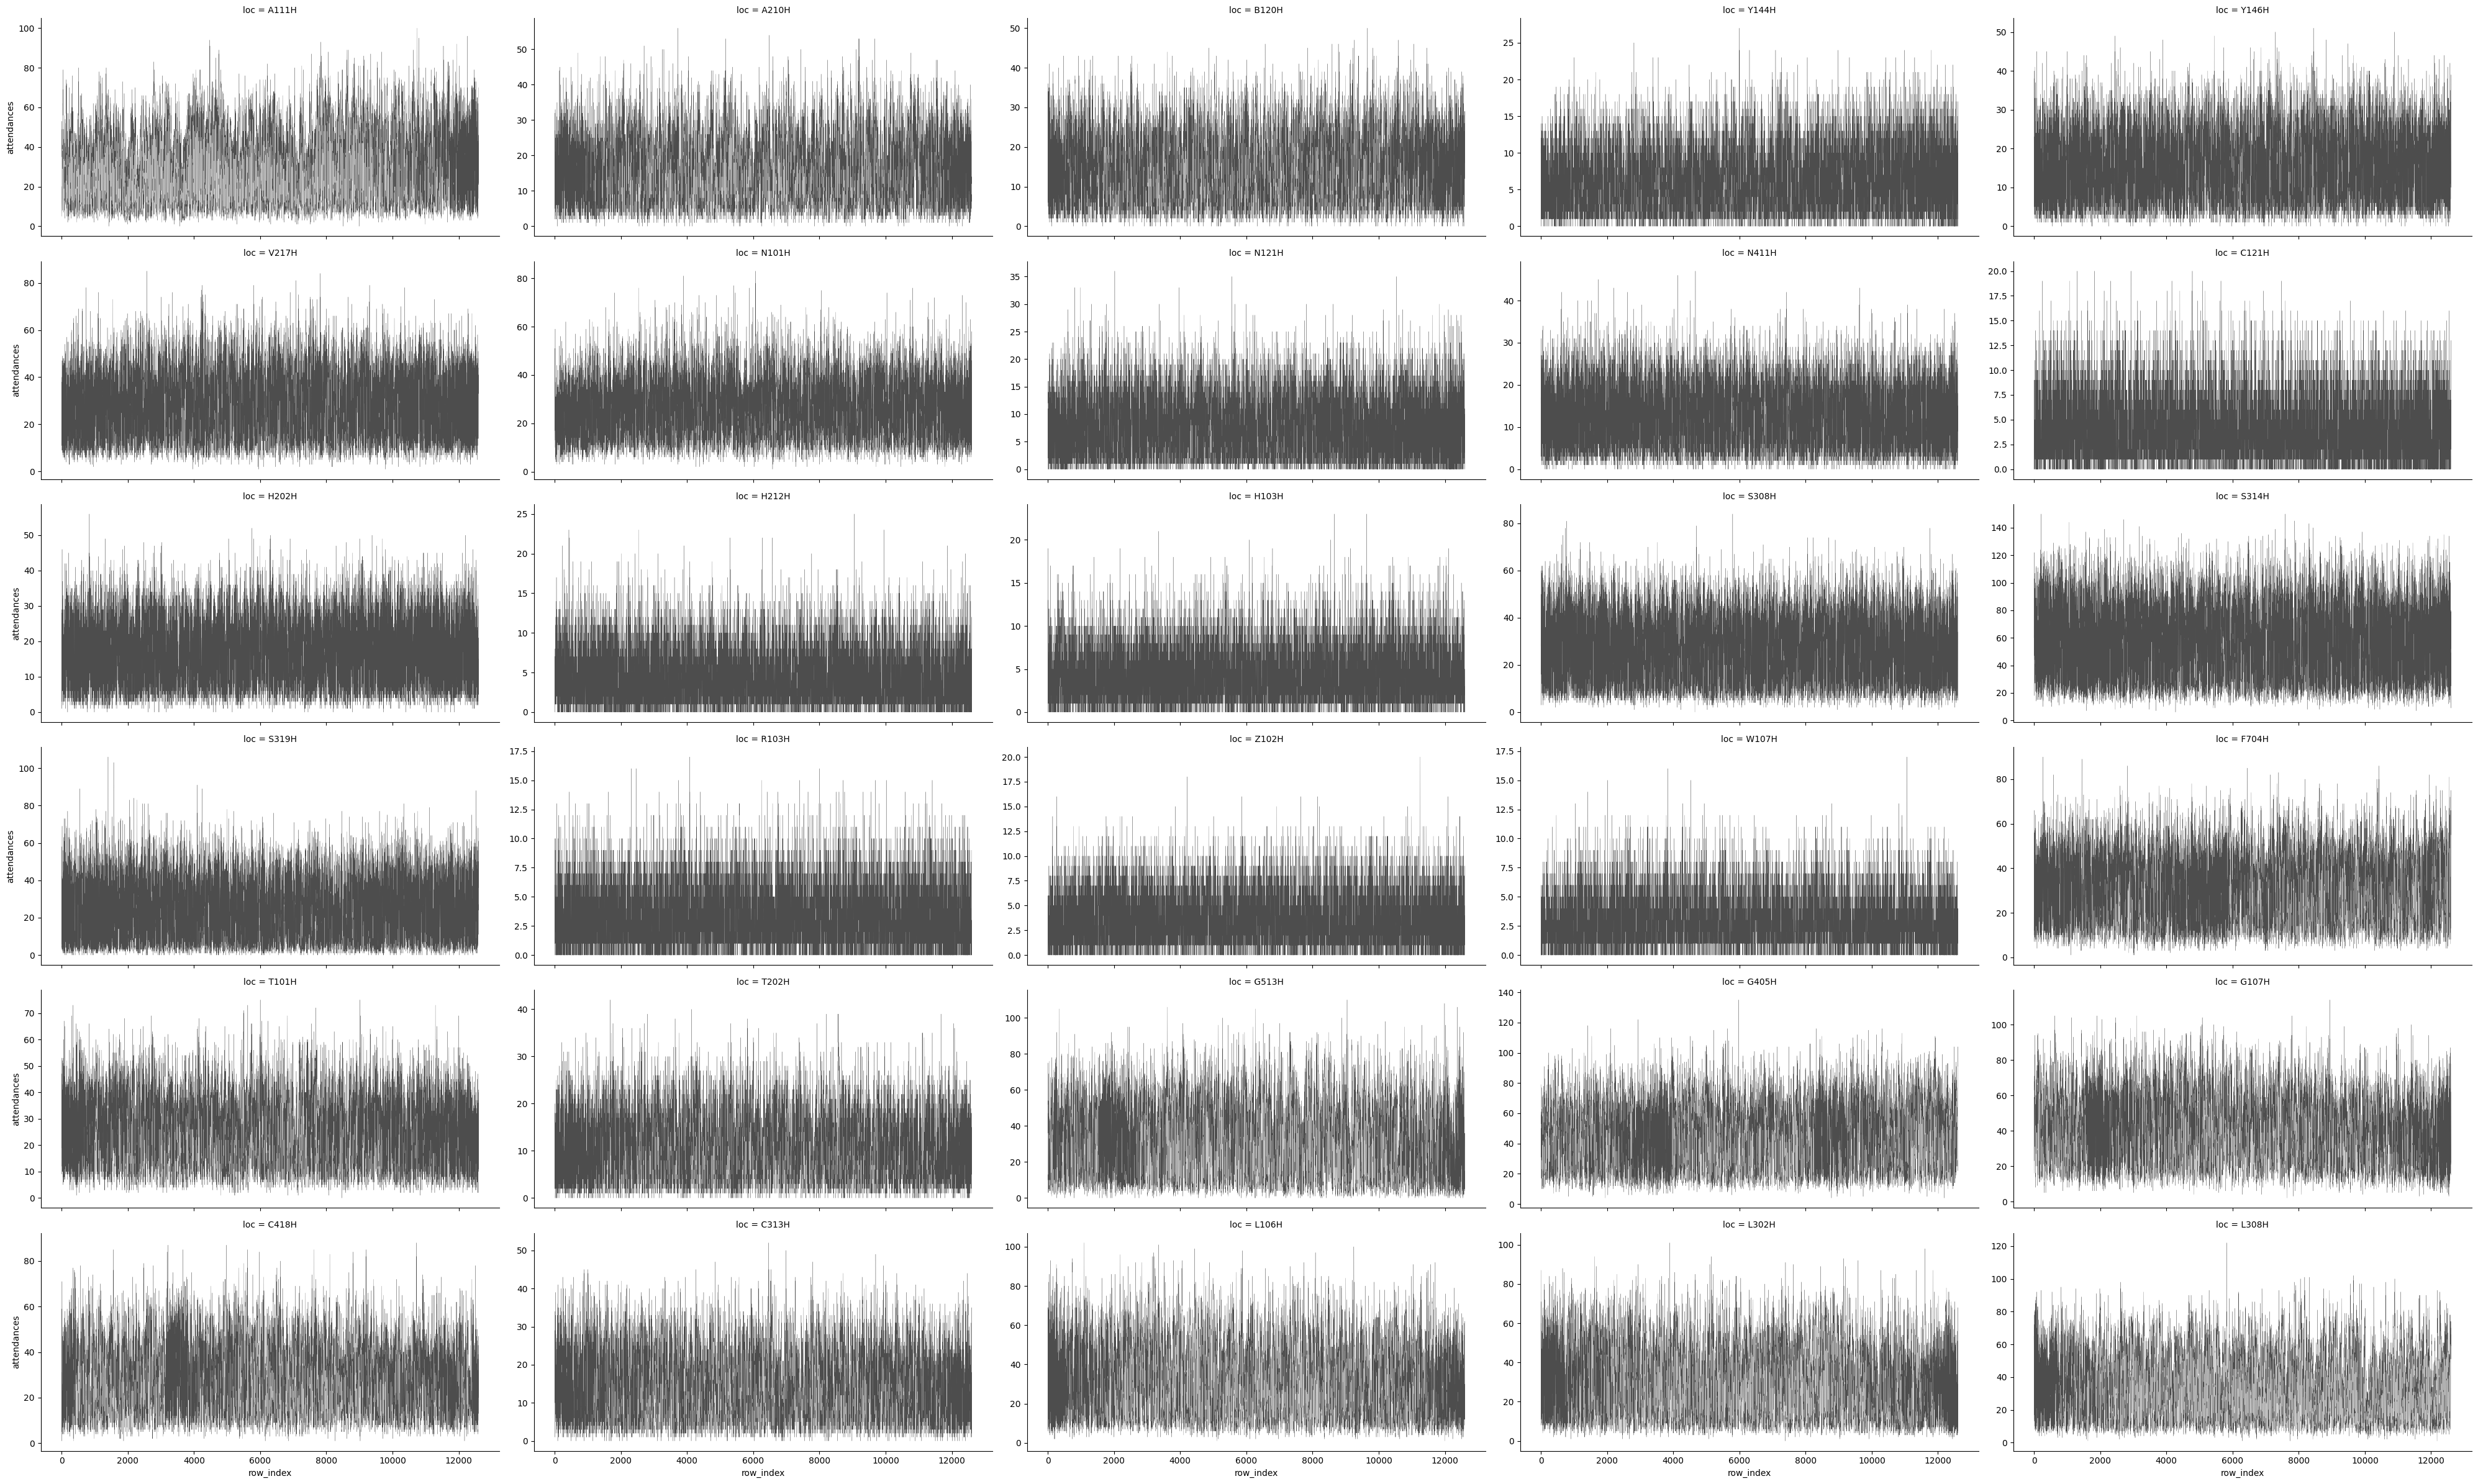

In [5]:
g = sns.FacetGrid(df, col="loc", col_wrap=5, height=4, aspect=2, sharey=False)
g.map(sns.lineplot, "row_index", "attendances", color=".3", linewidth=0.2, errorbar=None)

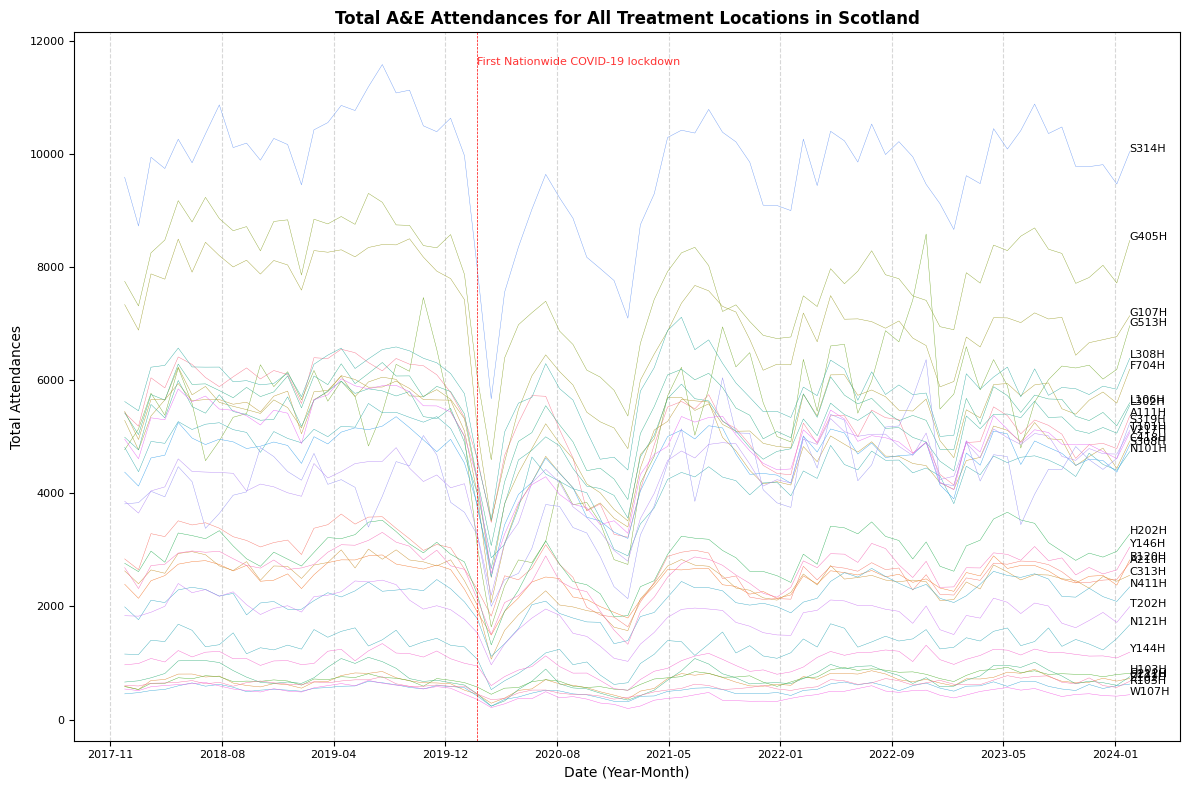

In [6]:
# Summarize data by month
df_month_plot = (
    df.groupby(['loc', 'year', 'month', 'cmonth', 'covid'])
    .agg(total_attendances=('attendances', 'sum'))
    .reset_index()
)
# Create a 'yearmon' column
df_month_plot['yearmon'] = pd.to_datetime(df_month_plot[['year', 'month']].assign(day=1))

# Filter for the last available date for each location
last_dates = df_month_plot.loc[df_month_plot.groupby('loc')['yearmon'].idxmax()]

# Plot the data
plt.figure(figsize=(12, 8))

sns.lineplot(
    data=df_month_plot,
    x='yearmon',
    y='total_attendances',
    hue='loc',
    linewidth=0.3,
    legend=False
)

# Add a vertical line for the COVID-19 lockdown
lockdown_date = pd.to_datetime("2020-03-01")
plt.axvline(x=lockdown_date, color='red', linestyle='--', linewidth=0.5)
plt.text(
    lockdown_date,
    df_month_plot['total_attendances'].max(),
    "First Nationwide COVID-19 lockdown",
    color='red',
    ha='left',
    fontsize=8,
    alpha=0.8,
)

# Annotate the last point for each location
for _, row in last_dates.iterrows():
    plt.text(
        row['yearmon'],
        row['total_attendances'],
        row['loc'],
        fontsize=8,
        color='black',
        ha='left',
    )

# Customize the plot
plt.title("Total A&E Attendances for All Treatment Locations in Scotland", fontsize=12, fontweight='bold')
plt.xlabel("Date (Year-Month)", fontsize=10)
plt.ylabel("Total Attendances", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Format the x-axis as year-month
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10))

# Show the plot
plt.tight_layout()
plt.show()

# Feature Engineering 

We need to conduct feature engineering to encode periocity into our data so our machine learning algorithm smoothly interprets values from 0 back to 23

Text(0.5, 1.0, 'Time of day signal')

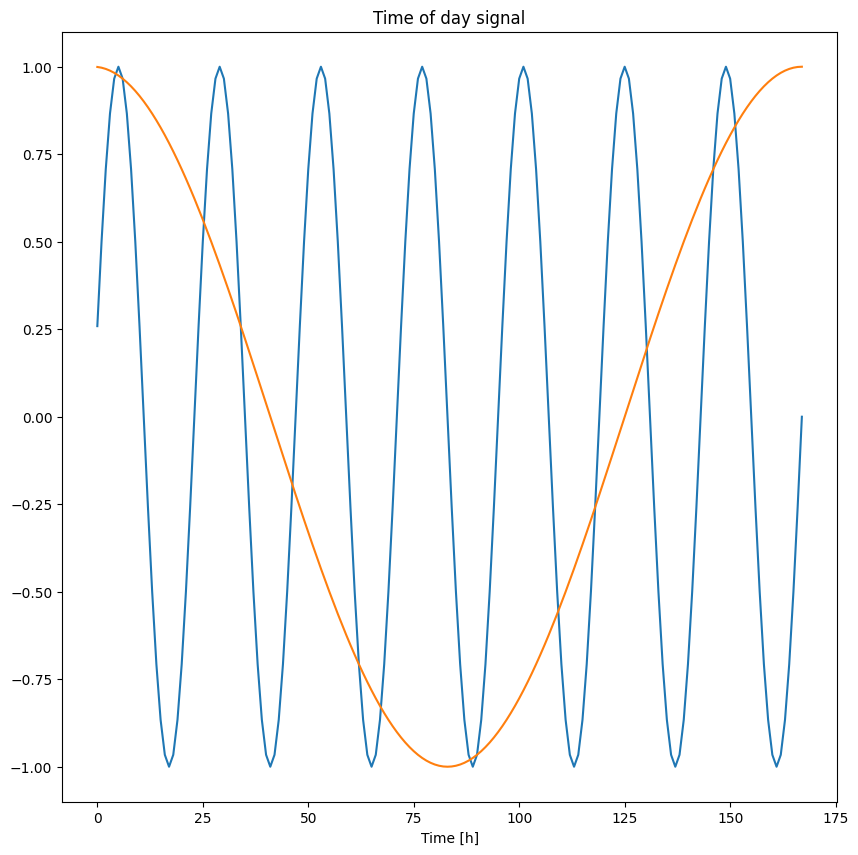

In [7]:
day_period = 24
week_period = 7 * day_period

# Sine and Cosine transformations
df['Hour sin'] = np.sin(2 * np.pi * (df['row_index'] % day_period)/day_period)
df['Hour cos'] = np.cos(2 * np.pi * (df['row_index'] % day_period) / day_period)
df['Week sin'] = np.sin(2 * np.pi * (df['row_index'] % week_period) / week_period)
df['Week cos'] = np.cos(2 * np.pi * (df['row_index'] % week_period) / week_period)

plt.plot(np.array(df['Hour sin'])[:168])
plt.plot(np.array(df['Week cos'])[:168])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [8]:
# One hot encoding for location
df = pd.get_dummies(df, columns=['loc'], dtype='float')

In [9]:
# Drop variables we don't need 
df_reduced = df.drop(['hr.num', 'day.num', 'year', 'month', 'cmonth', 'chr', 'covid','year_num', 'row_index'], axis=1)

In [10]:
df_reduced

,attendances,Hour sin,Hour cos,Week sin,Week cos,loc_A111H,loc_A210H,loc_B120H,loc_C121H,loc_C313H,...,loc_S308H,loc_S314H,loc_S319H,loc_T101H,loc_T202H,loc_V217H,loc_W107H,loc_Y144H,loc_Y146H,loc_Z102H
0,20,0.258819,0.965926,0.037391,0.999301,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14,0.500000,0.866025,0.074730,0.997204,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,0.707107,0.707107,0.111964,0.993712,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,0.866025,0.500000,0.149042,0.988831,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.965926,0.258819,0.185912,0.982566,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377995,74,-0.866025,0.500000,-0.149042,0.988831,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
377996,51,-0.707107,0.707107,-0.111964,0.993712,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
377997,57,-0.500000,0.866025,-0.074730,0.997204,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
377998,62,-0.258819,0.965926,-0.037391,0.999301,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Train, Val and Test Split
This will be done in a conventional way according to 70: 20: 10 for training, validation and testing

In [11]:
column_indices = {name: i for i, name in enumerate(df_reduced.columns)}

n = len(df_reduced)
train_df = df_reduced[0:int(n*0.7)]
val_df = df_reduced[int(n*0.7):int(n*0.9)]
test_df = df_reduced[int(n*0.9):]

num_features = df_reduced.shape[1]

# Normalize the data 
This ensures all inputs are to the same scale to prevent numerical instability. We have to apply normalization to the continuous variables, not the categorical ones.

In [34]:
# Identify continuous columns (excluding categorical ones)
cont_cols = [col for col in df_reduced.columns if 'loc' not in col] 
train_mean = train_df[cont_cols].mean()
train_std = train_df[cont_cols].std()

# Define a function to apply standardization only to continuous columns
def normalize(df):
    df = df.copy()  
    df[cont_cols] = df[cont_cols].apply(lambda col: (col - train_mean[col.name]) / train_std[col.name])
    return df

train_df = normalize(train_df)
val_df = normalize(val_df)
test_df = normalize(test_df)


# Create Data Windows

In [38]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [39]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [40]:
w2 = WindowGenerator(input_width=24, label_width=1, shift=1,
                     label_columns=['attendances'])
w2


Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['attendances']

In [41]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 25, 35)
Inputs shape: (3, 24, 35)
Labels shape: (3, 1, 1)


In [45]:
w2.example = example_inputs, example_labels

In [112]:
def plot(self, model=None, plot_col='attendances', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue
        
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
        if model is not None:
            predictions = model(inputs)
            print(f"Predictions shape: {predictions.shape}")  # Debugging line

            # Now plot the single 1-hour ahead prediction
            plt.scatter(self.label_indices, predictions[n, -1, label_col_index],  # Only plot the last prediction (1 hour ahead)
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')


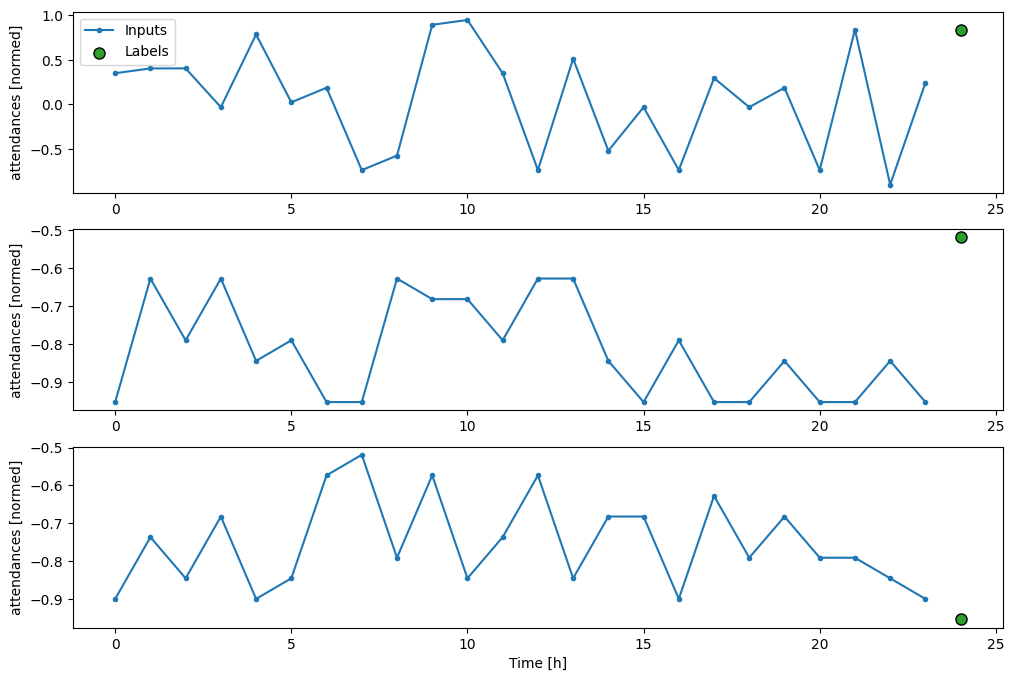

In [108]:
w2.plot()

# Generate tf.Data.datasets

In [49]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [51]:
w2.train.element_spec

(TensorSpec(shape=(None, 24, 35), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [52]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 35)
Labels shape (batch, time, features): (32, 1, 1)


2025-02-01 15:37:52.412949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Multi Time Step Linear Regression

In [ ]:
# Initialize a dictionary to store model performance
val_performance = {}
performance = {}

MAX_EPOCHS = 20

# Compile the model
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [66]:
# Create a 1 hour ahead prediction given 24 hours worth of data
hr_ahead_window = WindowGenerator(
    input_width=24,
    label_width=1,
    shift=1,
    label_columns=['attendances'])

In [114]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(1)  
])

In [115]:
print('Input shape:', hr_ahead_window.example[0].shape)
print('Output shape:', linear(hr_ahead_window.example[0]).shape)

Input shape: (32, 24, 35)
Output shape: (32, 24, 1)


In [116]:
history = compile_and_fit(linear, hr_ahead_window)

val_performance['Linear'] = linear.evaluate(hr_ahead_window.val, return_dict=True)
performance['Linear'] = linear.evaluate(hr_ahead_window.test, verbose=0, return_dict=True)

Epoch 1/20
8268/8268 ━━━━━━━━━━━━━━━━━━━━ 76s 9ms/step - loss: 0.7131 - mean_absolute_error: 0.6114 - val_loss: 1.9090 - val_mean_absolute_error: 1.0653
Epoch 2/20
8268/8268 ━━━━━━━━━━━━━━━━━━━━ 85s 10ms/step - loss: 0.4520 - mean_absolute_error: 0.4798 - val_loss: 1.9211 - val_mean_absolute_error: 1.0696
Epoch 3/20
8268/8268 ━━━━━━━━━━━━━━━━━━━━ 79s 10ms/step - loss: 0.4518 - mean_absolute_error: 0.4797 - val_loss: 1.9257 - val_mean_absolute_error: 1.0708
2362/2362 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 1.9332 - mean_absolute_error: 1.0739


Predictions shape: (32, 24, 1)
Predictions shape: (32, 24, 1)
Predictions shape: (32, 24, 1)


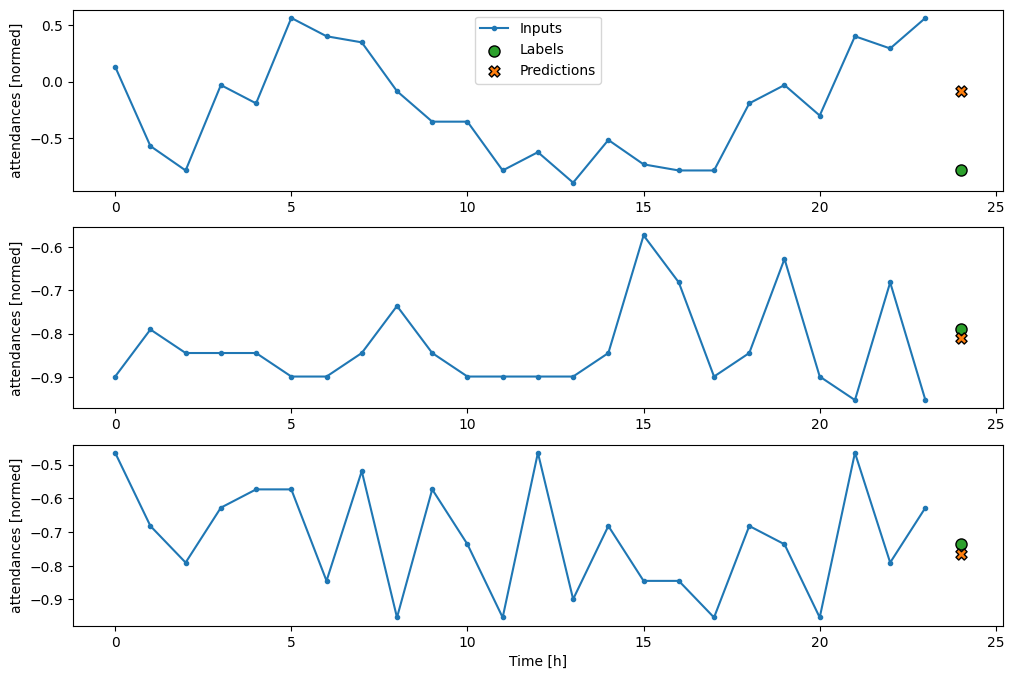

In [117]:
hr_ahead_window.plot(model=linear)

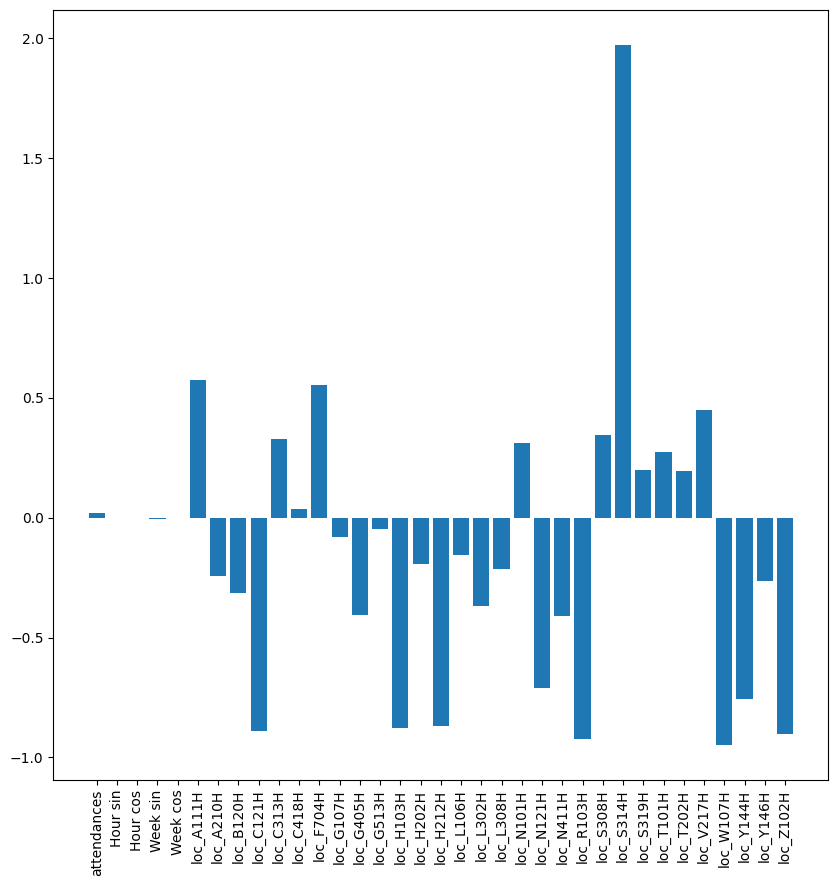

In [138]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

# Multi Time Step LSTM Model

In [131]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [132]:
print('Input shape:', hr_ahead_window.example[0].shape)
print('Output shape:', lstm_model(hr_ahead_window.example[0]).shape)

Input shape: (32, 24, 35)
Output shape: (32, 24, 1)


In [133]:
history = compile_and_fit(lstm_model, hr_ahead_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(hr_ahead_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(hr_ahead_window.test, verbose=0, return_dict=True)

2362/2362 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 1.1012 - mean_absolute_error: 0.8129


Predictions shape: (32, 24, 1)
Predictions shape: (32, 24, 1)
Predictions shape: (32, 24, 1)


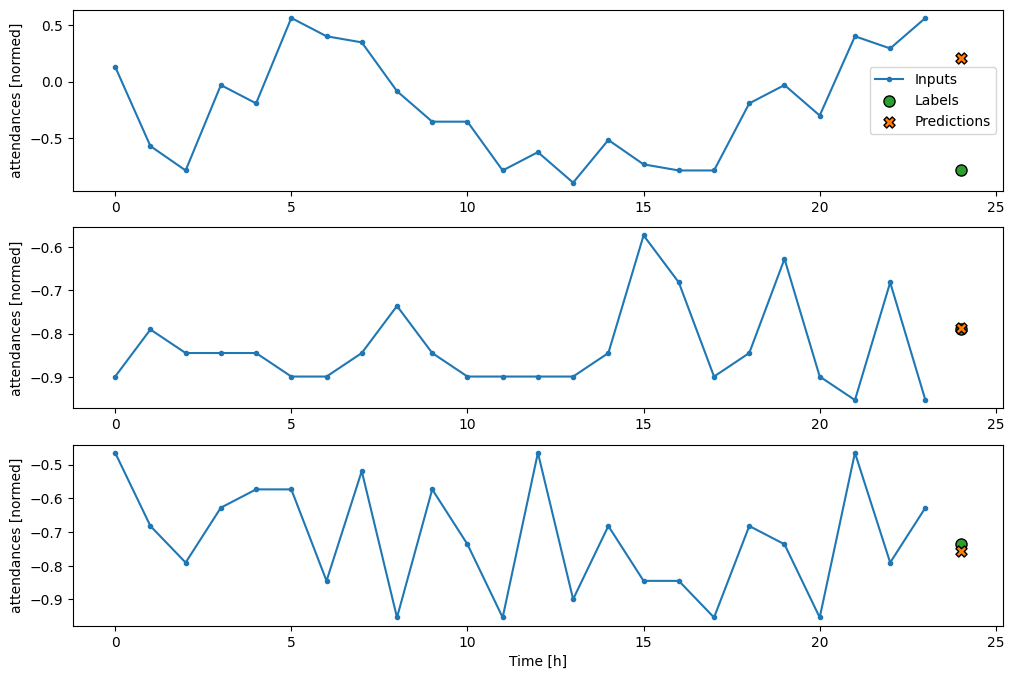

In [135]:
hr_ahead_window.plot(lstm_model)

# Multi Time Step Convolutional Neural Network Model

In [123]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(24,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [124]:
print("Conv model on `conv_window`")
print('Input shape:', hr_ahead_window.example[0].shape)
print('Output shape:', conv_model(hr_ahead_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 24, 35)
Output shape: (32, 1, 1)


In [125]:
history = compile_and_fit(conv_model, hr_ahead_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(hr_ahead_window.val, return_dict=True)
performance['Conv'] = conv_model.evaluate(hr_ahead_window.test, verbose=0, return_dict=True)

2362/2362 ━━━━━━━━━━━━━━━━━━━━ 693s 293ms/step - loss: 0.8218 - mean_absolute_error: 0.6951


Predictions shape: (32, 1, 1)
Predictions shape: (32, 1, 1)
Predictions shape: (32, 1, 1)


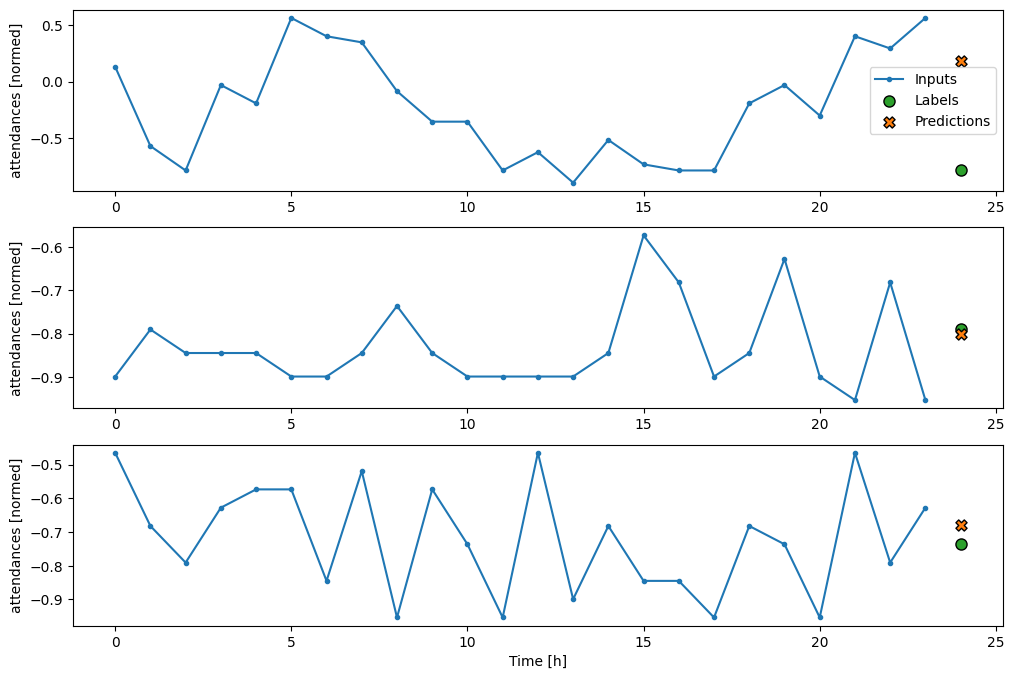

In [127]:
hr_ahead_window.plot(conv_model)

# Multi Time Step Neural Network 

In [128]:
neural_net = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(neural_net, hr_ahead_window)

val_performance['Dense'] = neural_net.evaluate(hr_ahead_window.val, return_dict=True)
performance['Dense'] = neural_net.evaluate(hr_ahead_window.test, verbose=0, return_dict=True)

Epoch 1/20
8268/8268 ━━━━━━━━━━━━━━━━━━━━ 93s 11ms/step - loss: 0.4832 - mean_absolute_error: 0.4966 - val_loss: 1.4659 - val_mean_absolute_error: 0.9508
Epoch 2/20
8268/8268 ━━━━━━━━━━━━━━━━━━━━ 107s 13ms/step - loss: 0.4572 - mean_absolute_error: 0.4816 - val_loss: 1.4019 - val_mean_absolute_error: 0.9477
Epoch 3/20
8268/8268 ━━━━━━━━━━━━━━━━━━━━ 108s 13ms/step - loss: 0.4559 - mean_absolute_error: 0.4809 - val_loss: 1.3989 - val_mean_absolute_error: 0.9506
Epoch 4/20
8268/8268 ━━━━━━━━━━━━━━━━━━━━ 97s 12ms/step - loss: 0.4555 - mean_absolute_error: 0.4808 - val_loss: 1.4124 - val_mean_absolute_error: 0.9536
Epoch 5/20
8268/8268 ━━━━━━━━━━━━━━━━━━━━ 87s 11ms/step - loss: 0.4553 - mean_absolute_error: 0.4808 - val_loss: 1.4155 - val_mean_absolute_error: 0.9556
2362/2362 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 1.4173 - mean_absolute_error: 0.9559


Predictions shape: (32, 24, 1)
Predictions shape: (32, 24, 1)
Predictions shape: (32, 24, 1)


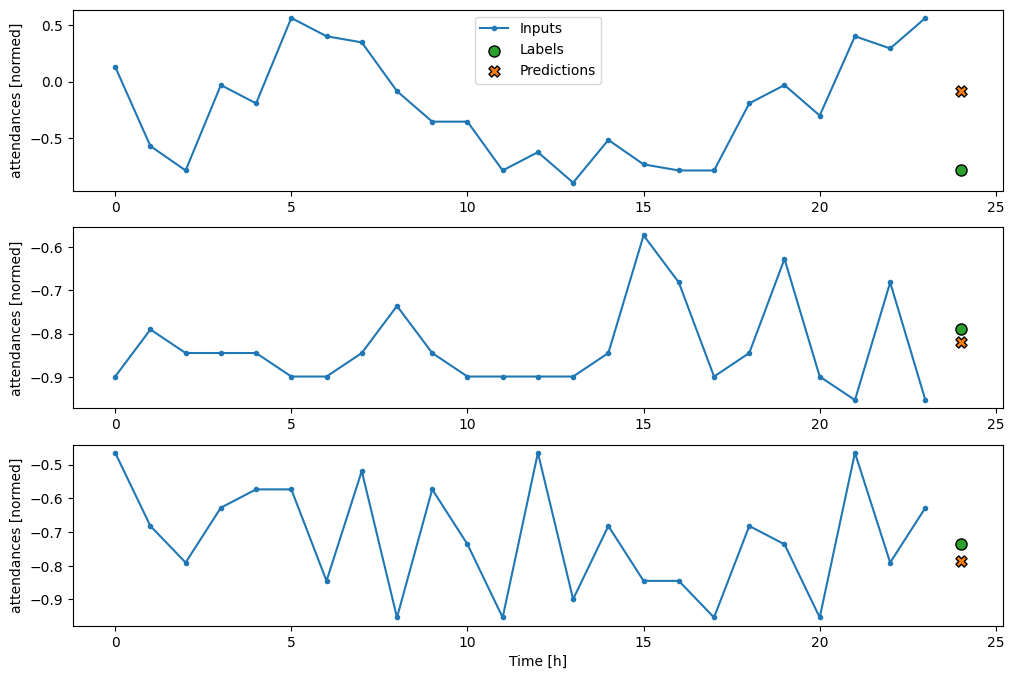

In [129]:
hr_ahead_window.plot(neural_net)

In [137]:
val_performance

{'LSTM': {'loss': 1.088294506072998,
  'mean_absolute_error': 0.8071397542953491},
 'Linear': {'loss': 1.9257136583328247,
  'mean_absolute_error': 1.0708426237106323},
 'Conv': {'loss': 0.8079109191894531,
  'mean_absolute_error': 0.6906696557998657},
 'Dense': {'loss': 1.4154589176177979,
  'mean_absolute_error': 0.9555824995040894}}